<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística I
Caderno de **Exercícios**<br> 
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Introdução ao Kaggle;</li>
  <li>Introdução ao problema de negócios;</li>
  <li>Exploração de dados.</li>
</ol>


---

# **Análise Exploratória de Dados de Logística**

# <font size=20>PARTE 1 (módulo 16)</font>

## 1\. Contexto

O intuito deste trabalho é fazer uma análise exploratória de dados logísticos. Sendo referentes à uma empresa real, a qual possui um grande acervo de informações de seus veículos, regiões atendidas, métricas de entrega e coordenadas. 

Bastante rica, desde análises, modelos ML, estudos de tomada de decisão são possíveis com estes registros. Apesar disso, o intuito se limitará no escopo da análise exploratória para fins didáticos. Para tanto:

*  Obter a base de dados;
*  Manuseá-los (wrangling);
*  Explorá-los (pandas, gráficos);
*  Análisá-los.

[Link](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json) para os dados (raw).

## 2\. Pacotes e bibliotecas

In [51]:
import json
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

## 3\. Exploração de dados

### 3.1 Coleta de dados

In [52]:
# Pegando arquivo base:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json 

# Atribuindo a uma variavel:
with open(file='deliveries.json', mode='r', encoding='utf8') as arq:
  carros_entregas = json.load(arq)

### 3.2 Wrangling da estrutura

In [53]:
# Tranformando em DF:
carros_df = pd.DataFrame(carros_entregas)

# INFOs básicas e qualidade:
carros_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              199 non-null    object
 1   region            199 non-null    object
 2   origin            199 non-null    object
 3   vehicle_capacity  199 non-null    int64 
 4   deliveries        199 non-null    object
dtypes: int64(1), object(4)
memory usage: 7.9+ KB


In [54]:
# Alguns registros:
carros_df.head(3)

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."


Colunas `origin` e `deliveries` precisam de tratamento:
*  `origin`: dict de duas chaves (normalizar direto ou extrair separado).
*  `deliveries`: Muitas entregas aninhadas p/ cada veículo. Desaninhar (explodir) e normalizar/extrair.

#### 3.2.1 Manipulando `entregas_df.origin`

In [55]:
# 1. Extraindo pontualmente pelas chaves:
carros_df['regiao long'] = carros_df['origin'].str.get('lng')
carros_df['regiao lat'] = carros_df['origin'].str.get('lat')

# 2. Excluindo coluna antiga:
carros_df.drop(columns='origin', inplace=True)

# 3. Check:
carros_df.head(3)

,name,region,vehicle_capacity,deliveries,regiao long,regiao lat
0,cvrp-2-df-33,df-2,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145


#### 3.2.2 Manipulando `entregas_df.deliveries`

In [56]:
# 1. Separando os dados em DF somente para as entregas dos veículos:
entregas_df = pd.DataFrame({'deliveries':carros_df.pop('deliveries')})

# 2. Desaninhando a lista de dicts:
entregas_df = entregas_df.explode('deliveries')

# 3. Preversando os índices originais (p/ joins com DF de veículos):
entregas_df_index = entregas_df.index

# 4. Normalizando/separando os dados das chaves em colunas:
entregas_df = pd.json_normalize(entregas_df['deliveries'])

# 5. Atribuindo o índice antigo ao DF:
entregas_df.index = entregas_df_index

# 6. Renomeando cols, removendo 'delivery' e check:
entregas_df.rename(columns={'id':'deliveryID', 'point.lat':'delivery lat', 'point.lng':'delivery long'}, inplace=True)
entregas_df.head(3)

,deliveryID,size,delivery long,delivery lat
0,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929
0,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772
0,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871


In [57]:
# carros C join entregas E on A.index = E.index:
carros_e_entregas_df = pd.merge(left=carros_df, 
                                right=entregas_df,
                                left_index=True,
                                right_index=True)
carros_e_entregas_df.head(3)

,name,region,vehicle_capacity,regiao long,regiao lat,deliveryID,size,delivery long,delivery lat
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871


#### 3.2.3 Resultado final

**`carros_df`**: DataFrame dos veículos, cubagem, regiões e suas coordenadas:

\

<center>

|index|name|region|vehicle\_capacity|regiao long|regiao lat|
|---|---|---|---|---|---|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|
|1|cvrp-2-df-73|df-2|180|-48\.05498915846707|-15\.83814451122274|
|2|cvrp-2-df-20|df-2|180|-48\.05498915846707|-15\.83814451122274|
|3|cvrp-1-df-71|df-1|180|-47\.89366206897872|-15\.80511751066334|
|4|cvrp-2-df-87|df-2|180|-48\.05498915846707|-15\.83814451122274|

</center>

\
**`entregas_df`**: DataFrame das entregas, volume de itens, coordenadas dos endereços de entrega:

\

<center>

|index|deliveryID|size|delivery long|delivery lat|
|---|---|---|---|---|
|0|313483a19d2f8d65cd5024c8d215cfbd|9|-48\.11618888384239|-15\.848929154862294|
|0|320c94b17aa685c939b3f3244c3099de|2|-48\.11819489551|-15\.850772371049631|
|0|3663b42f4b8decb33059febaba46d5c8|1|-48\.11248339849675|-15\.84787055941764|
|0|e11ab58363c38d6abc90d5fba87b7d7|2|-48\.11802268617869|-15\.846471025281456|
|0|54cb45b7bbbd4e34e7150900f92d7f4b|7|-48\.114898174591026|-15\.85805462185708|

</center>

\
**`carros_e_entregas_df`**: DataFrame resultante do join entre as tabelas anteriores via index:

\

<center>

|index|name|region|vehicle\_capacity|regiao long|regiao lat|deliveryID|size|delivery long|delivery lat|
|---|---|---|---|---|---|---|---|---|---|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|313483a19d2f8d65cd5024c8d215cfbd|9|-48\.11618888384239|-15\.848929154862294|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|320c94b17aa685c939b3f3244c3099de|2|-48\.11819489551|-15\.850772371049631|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|3663b42f4b8decb33059febaba46d5c8|1|-48\.11248339849675|-15\.84787055941764|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|e11ab58363c38d6abc90d5fba87b7d7|2|-48\.11802268617869|-15\.846471025281456|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|54cb45b7bbbd4e34e7150900f92d7f4b|7|-48\.114898174591026|-15\.85805462185708|

</center>

\


### 3.3 Exploração do schema

In [58]:
# - exploração do schema;
cubagem_avg = carros_df['vehicle_capacity'].mean()
size_avg = entregas_df['size'].mean().round(1)

print(f'''
               cubagem média: {cubagem_avg}
média de itens transportados: {size_avg}
''')


               cubagem média: 180.0
média de itens transportados: 5.5



Todos os veículos possuem a mesma cubagem e, de modo geral, a média de itens transportados é de 5,5.

In [59]:
# sub_df_1 -> total de itens entregues e total de entregas, por região:
sub_df_1 = carros_e_entregas_df[['region', 'name', 'size']]\
.groupby(['region'])\
.agg({'size':'sum', 'name':'count'}).reset_index()\
.sort_values('size', ascending=False)\
.rename(columns={'region':'regiao', 'size':'total de itens', 'name':'total de entregas'})

sub_df_1['itens/entrega'] = round(sub_df_1['total de itens'] / sub_df_1['total de entregas'], 2)

# sub_df_2 -> carros alocados por região:
sub_df_2 = carros_df[['region', 'name']]\
.groupby(['region'])\
.agg('count').reset_index()\
.rename(columns={'region':'regiao', 'name':'carros'})

sub_df_3 = pd.merge(left=sub_df_1,
                    right=sub_df_2,
                    on=['regiao'])

sub_df_3['itens entregues/carro'] = round(sub_df_3['total de itens'] / sub_df_3['carros'], 2)
sub_df_3['entregas/carro'] = round(sub_df_3['total de entregas'] / sub_df_3['carros'], 2)
sub_df_3

,regiao,total de itens,total de entregas,itens/entrega,carros,itens entregues/carro,entregas/carro
0,df-1,1681582,304708,5.52,66,25478.52,4616.79
1,df-2,1439010,261319,5.51,62,23209.84,4214.82
2,df-0,385932,70122,5.50,71,5435.66,987.63


Região 'df-1' é que mais se entregou e a 2ª região com maior quantidade de veículos.

A região 'df-0' possui a maior quantidade de veículos sendo a que menos se entregou. Apesar disso, a taxa de volume por entrega é bastante semelhante nas 3 regiões.

In [60]:
# agrupando
itens_por_item = \
carros_e_entregas_df[['region', 'size']]\
.groupby(['region', 'size']).agg({'size':'count'})

# arrumando
df=pd.DataFrame()
for index, row in itens_por_item.iterrows():
   dic = pd.DataFrame({'x':[index[0]+'|'+str(index[1])], 'regiao': [index[0]], 'itens': [index[1]], 'total': [row[0]]})
   df = pd.concat([df, dic])
df.reset_index(inplace=True, drop=True)

# plot
graf = px.bar(df,
              x = 'x',
              y = 'total', 
              color = 'regiao', 
              title = 'Total de entregas por região e volume da entrega', 
              labels={"x": "Região e volume da entrega",  
                      "y": "Contagem de entregas"},
              template="simple_white")
graf.add_hline(y=df[df['regiao']=='df-0']['total'].mean(), line_width=3, line_dash="dash", line_color="blue")
graf.add_hline(y=df[df['regiao']=='df-1']['total'].mean(), line_width=3, line_dash="dash", line_color="orange")
graf.add_hline(y=df[df['regiao']=='df-2']['total'].mean(), line_width=3, line_dash="dash", line_color="green")
graf

A contagem de entregas por seu volume é bem distribuida. Ou seja, nenhuma região apresenta tendência de entregar mais uma determinada quantidade que outra.

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



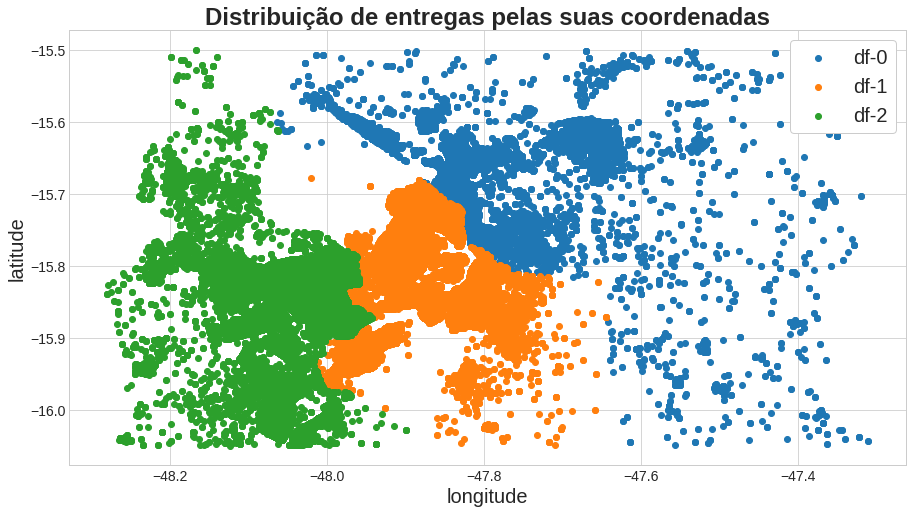

In [61]:
# preparando df
a = carros_e_entregas_df[['name', 'region', 'size', 'delivery long', 'delivery lat']]\
.groupby(['region', 'name', 'delivery long', 'delivery lat']).agg({'size':'count'}).reset_index()\
.rename(columns={'region':'regiao', 'name':'carro', 'size':'entregas'})

# plot
plt.style.use('seaborn-whitegrid')
plt.scatter(data=a[a['regiao']=='df-0'], x='delivery long', y='delivery lat', label='df-0')
plt.scatter(data=a[a['regiao']=='df-1'], x='delivery long', y='delivery lat', label='df-1')
plt.scatter(data=a[a['regiao']=='df-2'], x='delivery long', y='delivery lat', label='df-2')
plt.title('Distribuição de entregas pelas suas coordenadas', fontsize=24, fontweight='bold')
plt.xlabel('longitude', fontsize=20)
plt.ylabel('latitude', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(frameon = True, framealpha = 1, facecolor = 'white', fontsize=20)

De maneira simples, a disperção acima mostra as entregas clusterizadas pelas regiões. Enquanto 'df-1' tem suas entregas mais concentradas geograficamente, a região 'df-0' abrange uma área maior. Talvez por isso a necessidade maior de veículos alocados para atendê-la.

---

# <font size=20>PARTE 2 (módulo 17)</font>

## 1\. Contexto

Dando continuidade à problemática de entregas anterior, neste segundo momento, a análise se aprofundará sobre <font color=MediumPurple>questões geográficas</font>, como a distribuição de entregas nas diferentes cidades do Distrito Federal, bem como a dispersão destas propriamente em mapa da unidade federativa.

## 2\. Pacotes e bibliotecas

Não apenas os módulos anteriores são importantes, mas os seguintes módulos abaixo serão utilizados nesta 2ª etapa:

In [62]:
!pip3 install -q geopandas    # plotagem de mapas com GeoDataFrames
!pip install -q pandasql      # manipular DFs com sintaxe SQLite
import geopandas as gpd
from pandasql import sqldf

## 3\. Exploração dos dados

A partir dos datasets gerados no primeiro momento, algumas manipulações adicionais serão realizadas. Rebuscando:

`carros_df`

|index|name|region|vehicle\_capacity|regiao long|regiao lat|
|---|---|---|---|---|---|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|
|1|cvrp-2-df-73|df-2|180|-48\.05498915846707|-15\.83814451122274|
|2|cvrp-2-df-20|df-2|180|-48\.05498915846707|-15\.83814451122274|
|3|cvrp-1-df-71|df-1|180|-47\.89366206897872|-15\.80511751066334|
|4|cvrp-2-df-87|df-2|180|-48\.05498915846707|-15\.83814451122274|

`entregas_df`

|index|deliveryID|size|delivery long|delivery lat|
|---|---|---|---|---|
|0|313483a19d2f8d65cd5024c8d215cfbd|9|-48\.11618888384239|-15\.848929154862294|
|0|320c94b17aa685c939b3f3244c3099de|2|-48\.11819489551|-15\.850772371049631|
|0|3663b42f4b8decb33059febaba46d5c8|1|-48\.11248339849675|-15\.84787055941764|
|0|e11ab58363c38d6abc90d5fba87b7d7|2|-48\.11802268617869|-15\.846471025281456|
|0|54cb45b7bbbd4e34e7150900f92d7f4b|7|-48\.114898174591026|-15\.85805462185708|

`carros_e_entregas_df`

|index|name|region|vehicle\_capacity|regiao long|regiao lat|deliveryID|size|delivery long|delivery lat|
|---|---|---|---|---|---|---|---|---|---|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|313483a19d2f8d65cd5024c8d215cfbd|9|-48\.11618888384239|-15\.848929154862294|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|320c94b17aa685c939b3f3244c3099de|2|-48\.11819489551|-15\.850772371049631|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|3663b42f4b8decb33059febaba46d5c8|1|-48\.11248339849675|-15\.84787055941764|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|e11ab58363c38d6abc90d5fba87b7d7|2|-48\.11802268617869|-15\.846471025281456|
|0|cvrp-2-df-33|df-2|180|-48\.05498915846707|-15\.83814451122274|54cb45b7bbbd4e34e7150900f92d7f4b|7|-48\.114898174591026|-15\.85805462185708|


### 3.1. Obtendo as informações do par de coordenadas

#### 3.1.1 Dos centros de distribuição

Neste tópico, latitude e longitude são concatenadas, criando-se uma coluna única com ambos para, com uso de funções de busca geográfica (`geopy`), obter-se-á os dados, como código postal, cidade e bairro, do respectivo ponto cartesiano.

In [63]:
# 1. Criando DF com as coordenadas dos CDs:
regioes_coords = \
carros_df[['region', 'regiao lat', 'regiao long']]\
.drop_duplicates().sort_values('region')\
.reset_index(drop=True).rename(columns={'region':'regiao'})

# 2. Criando col com os pares de latitude e longitude:
regioes_coords['lat_long'] = \
regioes_coords['regiao lat'].astype(str) + ', ' + regioes_coords['regiao long'].astype(str)
regioes_coords

,regiao,regiao lat,regiao long,lat_long
0,df-0,-15.657014,-47.802665,"-15.657013854445248, -47.802664728268745"
1,df-1,-15.805118,-47.893662,"-15.80511751066334, -47.89366206897872"
2,df-2,-15.838145,-48.054989,"-15.83814451122274, -48.05498915846707"


In [64]:
# 3. Criando obj de geolocalização (geopy.geocoders.osm.Nominatim)
geolocalizador = Nominatim(user_agent='vih')

# 4. Criando obj de busca:
geo_code = RateLimiter(geolocalizador.reverse, min_delay_seconds=1)

# 5. Pra cada par de coordenadas, aplicar a busca de infos (busca->geo_code):
regioes_coords['geo info'] = regioes_coords['lat_long'].apply(geo_code)
regioes_coords

,regiao,regiao lat,regiao long,lat_long,geo info
0,df-0,-15.657014,-47.802665,"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-15.805118,-47.893662,"-15.80511751066334, -47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-15.838145,-48.054989,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [65]:
# 6. Extraindo os dicts da coluna com as infos obtidas com método .raw ('geo info'.raw), 
#    normalizando-as e unindo (join) com 'regioes_coords':
regioes_coords = pd.merge(left=regioes_coords, 
                          right=pd.json_normalize(regioes_coords['geo info'].apply(lambda x: x.raw)), 
                          left_index=True, right_index=True)\
                          .drop(columns=['geo info', 'lat', 'lon'])\
                          .rename(columns={'address.city':'city', 
                                           'address.suburb':'suburb', 
                                           'address.town':'town'})
regioes_coords

,regiao,regiao lat,regiao long,lat_long,place_id,licence,osm_type,osm_id,display_name,boundingbox,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,city,address.shop,address.house_number
0,df-0,-15.657014,-47.802665,"-15.657013854445248, -47.802664728268745",68906480,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,df-1,-15.805118,-47.893662,"-15.80511751066334, -47.89366206897872",138610967,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",...,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,df-2,-15.838145,-48.054989,"-15.83814451122274, -48.05498915846707",67585484,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [66]:
# Checando a consistência das INFOs:
regioes_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   regiao                  3 non-null      object 
 1   regiao lat              3 non-null      float64
 2   regiao long             3 non-null      float64
 3   lat_long                3 non-null      object 
 4   place_id                3 non-null      int64  
 5   licence                 3 non-null      object 
 6   osm_type                3 non-null      object 
 7   osm_id                  3 non-null      int64  
 8   display_name            3 non-null      object 
 9   boundingbox             3 non-null      object 
 10  address.amenity         1 non-null      object 
 11  address.road            3 non-null      object 
 12  address.residential     1 non-null      object 
 13  suburb                  2 non-null      object 
 14  town                    1 non-null      object

Por ter apenas 3 linhas, uma para cada região, é observável no próprio DF no retorno logo acima que há vários campos faltantes.
Dos principais, 'suburb', 'town' e 'city', estes têm, respectivamente, 2, 1 e 2 dados ausentes para as coordenadas dos centros de distribuição. Minimamente, é possível reorganizar como abaixo:

In [67]:
# 1. Separando INFOs obtidas dos CDs:

df_regioes = regioes_coords[['city', 'suburb', 'town']].copy()

# 2. Usando função pandasql.sqldf p/ reorganizar via SQLite INFOs faltantes:
df_regioes = \
sqldf(
    '''SELECT IFNULL(city, suburb) AS city
            , IFNULL(suburb, city) AS suburb 
       FROM df_regioes
''')

# 3. Unindo com INFOs de DF 'regioes' de 'regioes_coords':
df_regioes = pd.merge(left=regioes_coords[['regiao']], 
                      right=df_regioes, 
                      left_index=True, right_index=True)
df_regioes

,regiao,city,suburb
0,df-0,Sobradinho,Sobradinho
1,df-1,Brasília,Asa Sul
2,df-2,Taguatinga,Taguatinga


Pelo DF acima, a região que mais entrega, 'df-1', fica em Brasília, no bairro Asa Sul. Por ser um centro urbano e bastante populoso, faz sentido.

#### 3.1.2 Das entregas

Como são muitas entregas e para múltiplas consultas deve-se ter um delay de 1 seg/consulta, uma base já com os dados das entregas foi disponibilizado para download, substituindo o processo de extração via Nominatim.

In [68]:
# 1. Obtendo base de 600mil+ localidades de entrega:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

# 2. Inserindo em df:
entregas_localidades = pd.read_csv('deliveries-geodata.csv')
entregas_localidades.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [69]:
# Checando a consistência das INFOs:
entregas_localidades.info()

null_cities = entregas_localidades["delivery_city"].isna().sum()
null_subus = entregas_localidades["delivery_suburb"].isna().sum()
total = len(entregas_localidades)

print(f'''\n
cidades sem registro: {round((null_cities/total)*100, 2)}
bairros sem registro: {round((null_subus/total)*100, 2)}
  total de registros: {total}
''')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   delivery_lng     636149 non-null  float64
 1   delivery_lat     636149 non-null  float64
 2   delivery_city    634447 non-null  object 
 3   delivery_suburb  476264 non-null  object 
dtypes: float64(2), object(2)
memory usage: 19.4+ MB


cidades sem registro: 0.27
bairros sem registro: 25.13
  total de registros: 636149



Os registros sem um retorno de bairro compreendem 25% do total de 636.149 registros. 

In [70]:
# query nulos
registros_nulos = \
sqldf('''
SELECT COUNT(*) AS regs
FROM entregas_localidades
WHERE delivery_suburb IS NULL
   OR delivery_city IS NULL
''')

# query não nulos
registros_n_nulos = \
sqldf('''
SELECT COUNT(*) AS regs
FROM entregas_localidades
WHERE delivery_suburb IS NOT NULL
  AND delivery_city IS NOT NULL
''')

# results
print(f'''
nulos: {registros_nulos.iloc[0,0]}
não nulos: {registros_n_nulos.iloc[0,0]}
total: {registros_nulos.iloc[0,0]+registros_n_nulos.iloc[0,0]}
check: {len(entregas_localidades)}
não nulos perc.: {str(round(registros_n_nulos.iloc[0,0]/len(entregas_localidades)*100, 2))+"%"}''')


nulos: 159885
não nulos: 476264
total: 636149
check: 636149
não nulos perc.: 74.87%


Cerca de 75% dos casos retornaram registros de bairro e cidade.

#### 3.1.3 Análise das entregas

In [71]:
# Contagem de entregas por cidades
entregas_localidades_counts = \
entregas_localidades[['delivery_city', 'delivery_suburb']]\
.groupby(['delivery_city']).agg({'delivery_suburb':'count'})\
.reset_index().sort_values('delivery_suburb', ascending=False)\
.rename(columns={'delivery_city':'cidade', 'delivery_suburb':'total'}).reset_index(drop=True)

# plot
graf = px.bar(entregas_localidades_counts,
              x = 'cidade',
              y = 'total', 
              #color = 'delivery_suburb', 
              title = 'Total de entregas por cidade', 
              template="simple_white")
graf

Como quase 75% dos registros estão completos, pode-se observar que a cidade de Brasília é disparada a mais representativa em volume de entregas.

Taguatinga, a 2ª em volume de entregas, representa 30,5% do volume entrege em Brasília.

### 3.2. Plotagem geográfica das entregas

Diferente do final da parte 1, que foi vista uma dispersão simplificada, este tópico buscará observar a distribuição de entregas no mapa do Distrito Federal, bem como a localização dos centros de distribuição.

Como são mais de 600mil pontos de entrega, renderizar por `leaflet` ou `folium` estouraria a capacidade de memória. Portanto, optou-se pelo `geopandas`.

Assim, é necessário:
*  Obter as coordenadas do poligono do DF;
*  Converter as coordenadas de entrega e dos CDs em um registro interpretável pelo geopandas;
*  Converter os DataFrames em GeoDataframes;
*  Plotar o poligono do DF e as informações de entrega e CDs destes GeoDataFrames.

#### 3.2.1 Shape do DF do IBGE

Para plotar a camada do poligono do Distrito-Federal, primeiro obtêm-se as coordenadas deste poligono, disponibilizadas pelo IBGE.

In [72]:
# 1. Baixando os arquivos zipados do ibge (year version: 2022):
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2022/shapefile/bc100_godf_2022-11-14_shp.zip" -O distrito-federal.zip

# 2. Extraindo (unzip) os arquivos para pasta 'maps' no diretório padrão:
!unzip -q distrito-federal.zip -d ./maps

# 3. Copiando (!cp) da pasta 'maps/SHP' os arquivos shapefile e shapeindex das unidades federativas p/ 'frente':
!cp ./maps/SHP/lml_unidade_federacao_a.shp ./distrito-federal.shp
!cp ./maps/SHP/lml_unidade_federacao_a.shx ./distrito-federal.shx

replace ./maps/SHP/aer_complexo_aeroportuario_p.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#### 3.2.2 Manuseando os dados e gerando os geoDFs

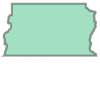

In [73]:
# 1. Lendo e atribuindo o conteúdo do aquivo em uma variável
map_df = gpd.read_file("distrito-federal.shx")

# 2. Dentro da var com shapeindex (shx), encontrando o shape do DF
map_df.iloc[1,0]  # DF

In [74]:
# 3. Atribuindo o shape a uma variável DataFrame do geopandas
map_df = gpd.GeoDataFrame({'geometry':[map_df.iloc[1,0]]})
map_df

,geometry
0,"POLYGON ((-47.30850 -16.04997, -47.30997 -16.0..."


In [75]:
########### ENTREGAS ###########

# 1. Convertendo as coordenadas de entrega em par de coordenadas interpretável pelo geopandas,
#    unindo ao DF das entregas e gerando o DataFrame do geopandas
carros_e_entregas_geo = \
gpd.GeoDataFrame(carros_e_entregas_df, 
                 geometry=gpd.points_from_xy(x = carros_e_entregas_df['delivery long'], 
                                             y = carros_e_entregas_df['delivery lat'])
                 )
carros_e_entregas_geo.head(3)

,name,region,vehicle_capacity,regiao long,regiao lat,deliveryID,size,delivery long,delivery lat,geometry
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929,POINT (-48.11619 -15.84893)
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772,POINT (-48.11819 -15.85077)
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871,POINT (-48.11248 -15.84787)


In [76]:
########### CDs ###########

# 1. Filtrando registros únicos de regiões e coordenadas dos CDs
CD_df = \
carros_e_entregas_df[['region', 'regiao long', 'regiao lat']]\
.drop_duplicates().reset_index(drop=True)

# 2. Criando geoDF com os pares de coordenadas interpretáveis por gpd & plt
CD_df = gpd.GeoDataFrame(CD_df, 
                         geometry=gpd.points_from_xy(CD_df["regiao long"], 
                         CD_df["regiao lat"])
                         )

print(f'''tipo: {type(CD_df)}\n\n{CD_df}''')

tipo: <class 'geopandas.geodataframe.GeoDataFrame'>

  region  regiao long  regiao lat                     geometry
0   df-2   -48.054989  -15.838145  POINT (-48.05499 -15.83814)
1   df-1   -47.893662  -15.805118  POINT (-47.89366 -15.80512)
2   df-0   -47.802665  -15.657014  POINT (-47.80266 -15.65701)


#### 3.2.3 Plotagem

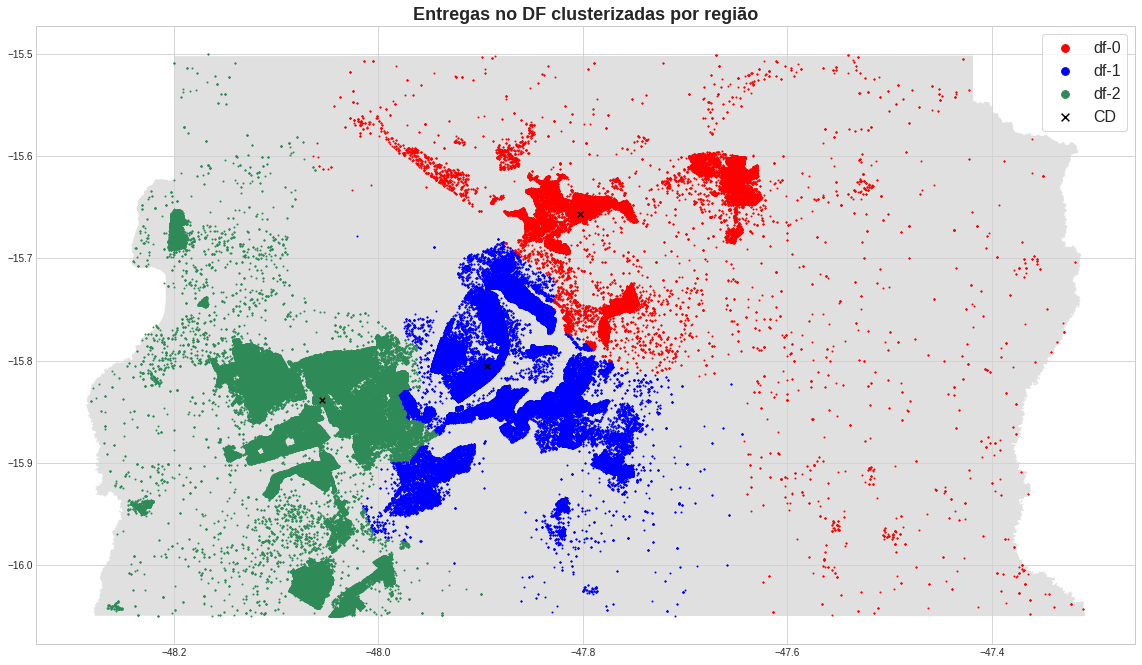

In [77]:
fig, ax = plt.subplots(figsize = (19.7, 19.7))

# 1. plot mapa do distrito federal
map_df.plot(ax=ax, alpha=0.7, color="lightgrey")

# 2. plot das entregas com os points no geodf
carros_e_entregas_geo.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
carros_e_entregas_geo.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
carros_e_entregas_geo.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# 3. plot Centros de Distribuição com os points em geodf
CD_df.plot(ax=ax, markersize=30, marker="x", color="black", label="CD")

# 4. Ajustes de título e legenda
plt.title(label='Entregas no DF clusterizadas por região', 
          fontdict={"fontsize": 18, 'fontweight':'bold'})
lgnd = plt.legend(prop={'size': 16}, 
                  frameon=True)
for handle in lgnd.legendHandles:
    handle.set_sizes([60])

A princípio, os CDs apresentam boa distribuição em relação a sua distância de suas entregas.

Claramente a região 'df-0' tem a maior dispersão de entregas no DF, abrangendo áreas mais distantes dos grandes centros e, além dos pontos espalhados, algumas "sub-áreas" de entrega espalhadas. Reforçando a ideia de uma disponibilidade maior de veículos para atendê-la.

A região 'df-1', de maior volume de entregas, atende os centros urbanos. Como visto anteriormente, Brasília é disparada a cidade que mais se tem demanda e compreende esta regiao.

A região 'df-2' está no meio termo, com uma grande concentração no entorno do CD e atendendo algumas regiões mais distantes.